# .NET Native Interop Performance Report

The following report evaluates the performance overhead of calling native C/C++ functions from managed C# code using the built-in interoperability capabilities of .NET known as P/Invoke (short for Platform Invocation Services). The report presents benchmarks of common interop scenarios that invole marshalling and passing values of primitive types, strings, arrays, and structures, in both directions (i.e. as both function parameters and return values or out parameters). Several ways of implementing the interop calls that have been added to the .NET framework throughout the years, namely the `DllImport` attribute, the source-generator backed `LibraryImport` attribute, and unmanaged function pointers are compared.

The benchmarks were executed on three .NET runtime versions as permitted by their respective supported feature sets: .NET Framework 4.8 (the last major version of the classic Windows-only runtime), .NET 6 (current LTS version of the portable .NET Core runtime) and the latest .NET 8 Preview. Results from Windows and Linux (x64) platforms are compared for the latter two runtimes.

## Overview of P/Invoke

Data type is called blittable if it has the same representation in managed and unmanaged memory. Such types therefore do not need conversion when passed between .NET and native code. In the case of reference types (or value types passed as `ref` parameters) this means that instead of copying the value to the unmanaged memory a pointer to the value's location in the managed memory can be passed where it can be accessed by the native code directly. This saves one copy for *in* parameters and up to two copies for *out* copies.

Non-blittable types are conversely types that do need special marshalling during interop. These types include:

- Strings
- Bools
- Arrays other than one-dimensional arrays of blittable types
- Structures and classes containing any non-blittable field, including array fields (with the exception of arrays with compile-time constant size) 

In [1]:
import glob
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import sys

color_map = dict(zip(
    ["Managed", "DllImport", "LibraryImport", "FuncPointers"],
    ["#79ccb3","#e9724d", "#d6d727", "#92cad1", ]
))

order_map = dict(zip(
    ["Managed", "DllImport", "LibraryImport", "FuncPointers"],
    [10, 20, 30, 40]
))


def load_results_file(run_dir: str) -> pd.DataFrame:
    results_dir = run_dir + "/results"
    file = glob.glob(results_dir + "/*measurements.csv")[0]
    df = pd.read_csv(file, delimiter=";")
    return df

def make_barplot(input_df: pd.DataFrame, title, unit, category = None, param = None, figsize = (14, 6)):
    category_df = input_df if category is None else input_df.query(f"Category == '{category}'")
    grouped_df = category_df.groupby(["Target_Type", "Target_Method", "Job_Runtime"])

    items = []
    methods = {
        ".NET 4.8": set(),
        ".NET 6.0": set(),
        ".NET 8.0": set(),
    }

    for keys, data in grouped_df:
        (type, method, runtime) = keys
        runtime_version = ".NET " + runtime.split(" ")[-1]
        case = f"{type}-{method}"
        methods[runtime_version].add(case)

        for val in data["Measurement_Value"].to_list():
            items.append({
                "Type": type,
                "Runtime": runtime_version,
                "Value": val if unit == "ns" else val / 1000.0 / 1000.0,
                "Order": order_map[type],
                "Color": color_map[type]
            })

    items.sort(key=lambda x: x["Order"])

    method_total = sum(map(len, methods.values()))
    method_ratios = list(map(lambda x: len(x) / method_total, methods.values()))

    input_df = pd.DataFrame(items)

    fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True, gridspec_kw={'width_ratios': method_ratios})
    fig.suptitle(title, fontsize=16, fontweight="bold")
    fig.supylabel(f"Mean execution time ({unit})", fontsize=12)

    for i, runtime in [(0, ".NET 4.8"), (1, ".NET 6.0"), (2, ".NET 8.0")]:
        _df = input_df[input_df.Runtime == runtime]
        sns.barplot(
            ax=ax[i],
            data=_df,
            x="Type", y="Value",
            palette=color_map,
            saturation=1.0
        )

        ax[i].bar_label(ax[i].containers[0], fmt='%.2f', label_type="center")
        ax[i].set_xlabel("")
        ax[i].set_ylabel("")
        ax[i].set_title(runtime, fontsize=12)

    plt.show()

In [2]:
data_Void_Empty = load_results_file("ReportData/Void_Empty_2023-09-21T00_21_17")
data_Primitive_Int_Out = load_results_file("ReportData/Primitive_Int_Out_2023-09-21T00_38_07")

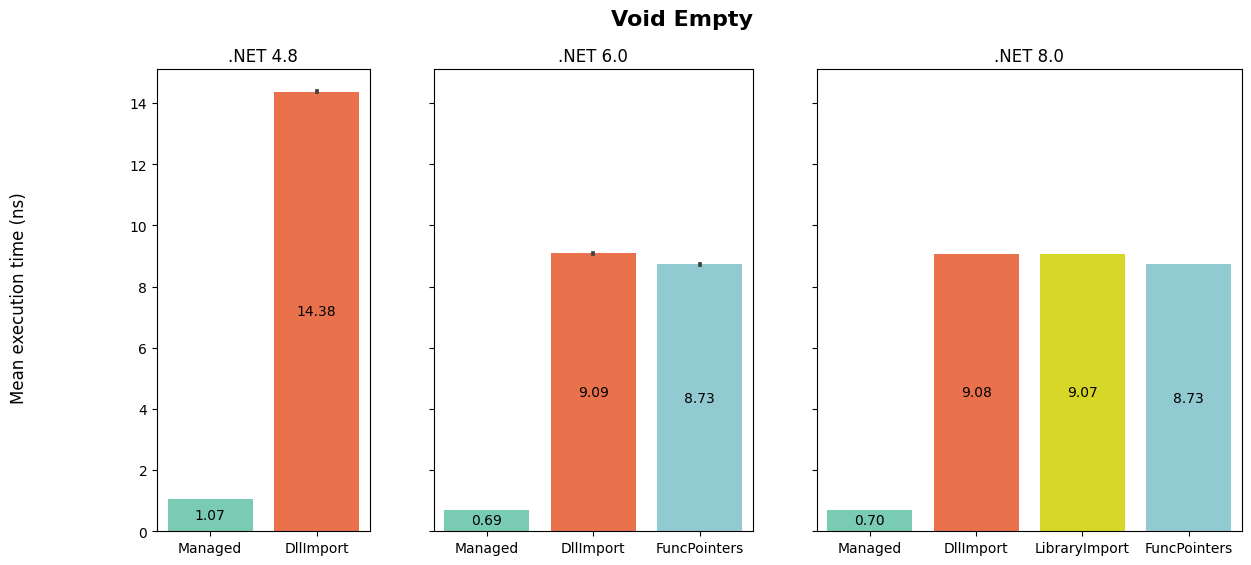

In [3]:
make_barplot(data_Void_Empty, "Void Empty", "ns")

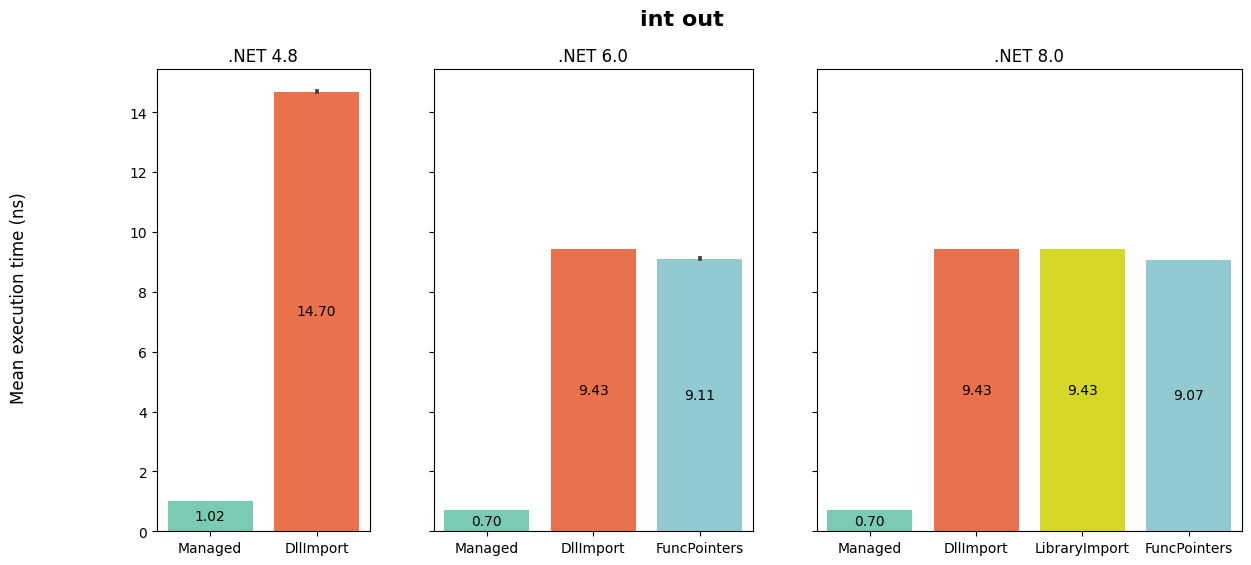

In [4]:
make_barplot(data_Primitive_Int_Out, "int out", "ns")